<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [2]:
import numpy as np
import gensim
from collections import Counter
import re
import sys

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pandas as pd

In [4]:
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [5]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [6]:
def clean_text(text):
    text = text.replace('\n', ' ') # remove newline
    text = text.replace('/', ' ')  # remove forward slashes
    text = re.sub(r'[^a-zA-Z ^0-9]', '', text) # letters and numbers only
    text = text.lower() # lower case everything
    text = re.sub(r'(x.[0-9])', '', text)  # remove special 
    return text

df['reviews.text'] = df.apply(lambda x: clean_text(x['reviews.text']), axis=1)

In [7]:
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)
STOP_WORDS = nlp.Defaults.stop_words.union(['as', 'well', 'I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this'])

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [8]:
reviews = df.shape[0]
texts = []

for i in range (0, reviews):
    texts.append(tokenize(df['reviews.text'][i]))

In [9]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(texts)

# Removal extreme values
id2word.filter_extremes(no_below=5, no_above=0.95)

# Creating BOW
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
# LDA model
lda = LdaMulticore(corpus=corpus,    # data
                   id2word=id2word,  # dictionary
                   random_state=723812, # different results 
                   num_topics = 15, 
                   passes=10,        # default is 100
                   workers=8
                  )

In [11]:
# Strip out the words
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

topics = [' '.join(t[0:5]) for t in words]


for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
tablet great apps amazon good

------ Topic 1 ------
tablet kindle best love great

------ Topic 2 ------
batteries great good long work

------ Topic 3 ------
loves bought old gift year

------ Topic 4 ------
books tablet love time games

------ Topic 5 ------
price great batteries good product

------ Topic 6 ------
amazon hd great battery time

------ Topic 7 ------
tablet kids great games love

------ Topic 8 ------
good battery great works tablet

------ Topic 9 ------
amazon batteries dont long like

------ Topic 10 ------
easy use kindle screen love

------ Topic 11 ------
batteries love box amazon come

------ Topic 12 ------
great price bought tablet perfect

------ Topic 13 ------
good far better kindle new

------ Topic 14 ------
use tablet like kindle amazon



In [15]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [16]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus, 
                                            limit=20)

In [17]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.543968
1,0,5,-2.594183
2,0,8,-2.743142
3,0,11,-2.629855
4,0,14,-2.765463


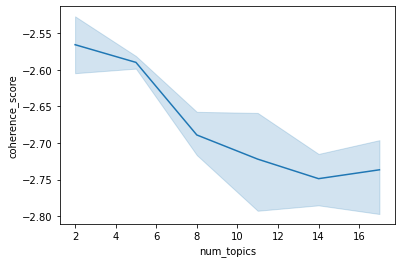

In [18]:
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [21]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.022248724),
 (1, 0.022248708),
 (2, 0.022248708),
 (3, 0.022248747),
 (4, 0.022248708),
 (5, 0.022248708),
 (6, 0.022248711),
 (7, 0.022248708),
 (8, 0.022248708),
 (9, 0.022248708),
 (10, 0.022248708),
 (11, 0.022248708),
 (12, 0.022248708),
 (13, 0.35565642),
 (14, 0.35511035)]

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling